In [1]:
import os, glob, math, random
from datetime import datetime
from scipy import stats
from sklearn import metrics
import math
import pandas as pd
import rasterio
from datetime import datetime
import zlib
from pyproj import CRS, Transformer

from matplotlib.collections import LineCollection
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from rasterio.plot import show as rio_show
import re
from rasterio.transform import array_bounds
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from tqdm import tqdm
import pickle
from matplotlib import patheffects as pe
import shapefile
import math, torch, torch.nn as nn, torch.nn.functional as F
from scipy.spatial.distance import pdist, squareform
from scipy.ndimage import gaussian_filter
import csv
import numpy as np
import torch
import scipy
import warnings
import cv2
import sys
sys.path.insert(0, os.path.abspath('..'))
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import DataLoader,Dataset
import torch
# Ignore all warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
from sklearn.metrics import r2_score
import torch.nn.functional as F
import torchvision.transforms.functional as TF
class Normalizer:
    """
    Image normalization (log1p + robust/global z) + Pandora normalization.
    Fit ONLY on training data to avoid leakage.
    """
    def __init__(self, clip_z=5.0,enforce_nonneg=True):
        self.clip_z = float(clip_z)
        self.enforce_nonneg = bool(enforce_nonneg)
        self.im_mu = None
        self.im_sigma = None       

    def fit_images(self, tif_paths):
        vals = []
        f32min = np.float32(-3.4028235e+38).item()

        for p in tif_paths:
            with rasterio.open(p) as src:
                arr = src.read(1).astype("float64")            
            m = np.isfinite(arr) & (arr > f32min*0.9)
            if self.enforce_nonneg:
                arr = np.where(m, np.maximum(arr, 0.0), np.nan) #clip negatives to zero
                m = np.isfinite(arr) #sanity check
                
            v = np.log1p(arr[m])  # log1p
            if v.size:
                vals.append(v)
        if not vals:
            raise RuntimeError("No valid pixels found to fit image normalizer.")
        allv = np.concatenate(vals)
        mu = np.median(allv)
        iqr = np.percentile(allv, 75) - np.percentile(allv, 25)
        sigma = max(iqr / 1.349, 1e-6)
        self.im_mu, self.im_sigma = float(mu), float(sigma)

    def normalize_image(self, arr_float64):
        f32min = np.float32(-3.4028235e+38).item()
        m = np.isfinite(arr_float64) & (arr_float64 > f32min * 0.9)
        x = arr_float64.copy()
        if self.enforce_nonneg: x[m] = np.maximum(x[m], 0.0)
        z = np.zeros_like(x, dtype=np.float32)
        z[~m] = 0.0
        z[m] = ((np.log1p(x[m]) - self.im_mu) / self.im_sigma)
        z[m] = np.clip(z[m], -self.clip_z, self.clip_z)
        return z

    def denormalize_image(self, z_float32):
        z = np.clip(z_float32.astype("float64"), -5, 5)  # match training range
        return np.expm1(z * self.im_sigma + self.im_mu)
    
    
def custom_collate_fn(batch):
    out = {}
    keys = batch[0].keys()
    for k in keys:
        v0 = batch[0][k]
        if isinstance(v0, torch.Tensor):
            out[k] = torch.stack([b[k] for b in batch], dim=0)
        else:
            # Keep as list so we can index it later
            out[k] = [b[k] for b in batch]
    return out

In [2]:
df_missing = pd.read_csv("/work/srs108/pconv2d/missing.csv")
if "percent_missing" not in df_missing.columns:
    raise ValueError("missing.csv must contain a 'percent_missing' column")

complete = df_missing[df_missing["percent_missing"] <= 60]["filename"].tolist()

train_files, val_files = train_test_split(complete, test_size=0.2, random_state=42)
tif_dir = '/work/srs108/bigs'
normalizer = Normalizer(clip_z=5.0)

# normalizer.fit_images(train_files)
# np.savez("normalizer_stats.npz",
#          im_mu=normalizer.im_mu, im_sigma=normalizer.im_sigma)

z = np.load("/hpc/home/srs108/normalizer_stats.npz", allow_pickle=True)
normalizer.im_mu = float(z["im_mu"]); normalizer.im_sigma = float(z["im_sigma"])
shp_path="/work/srs108/pconv2d/cus/cb_2018_us_state_500k.shp"
pandora_df = pd.read_csv("/work/srs108/pconv2d/pandora_filtered_data_old.csv", header =0)
pandora_df["datetime"] = pd.to_datetime(pandora_df["datetime"], errors="coerce")
stations_all = pandora_df["station"].unique()
station_color_map = dict(zip(stations_all, cm.tab20c(np.linspace(0, 1, len(stations_all)))))

In [3]:
def load_shapefile_segments_pyshp(shp_path, target_crs, src_epsg = 4326):
    """
    Load shapefile segments and transform to target CRS
    """
    src_crs = CRS.from_epsg(src_epsg)  # You'll need to determine source CRS
    tgt = target_crs if hasattr(target_crs, "to_wkt") else None
    if tgt is None:
        return None
    
    transformer = Transformer.from_crs(src_crs, target_crs, always_xy=True)

    r = shapefile.Reader(shp_path)
    segments = []
    for shapeRec in r.shapeRecords():
        shp = shapeRec.shape
        pts = np.asarray(shp.points, dtype=float)
        if pts.size == 0: 
            continue
        xs, ys = transformer.transform(pts[:,0], pts[:,1])
        pts_t = np.column_stack([xs, ys])
        parts = list(shp.parts) + [len(pts_t)]
        for i in range(len(parts)-1):
            seg = pts_t[parts[i]:parts[i+1]]
            if seg.shape[0] >= 2:
                segments.append(seg)
    return segments

def _wrap_lon_180(lons):
    """Normalize longitudes to [-180, 180]."""
    arr = np.asarray(lons, dtype=float)
    m = np.isfinite(arr)
    arr[m] = ((arr[m] + 180.0) % 360.0) - 180.0
    return arr
def _lonlat_to_rowcol_vec(lons, lats, transform, raster_crs):

    lons = np.asarray(lons, dtype=float)
    lats = np.asarray(lats, dtype=float)
    # mask invalid inputs
    good = np.isfinite(lons) & np.isfinite(lats)
    rows = np.full_like(lons, fill_value=np.nan, dtype=float)
    cols = np.full_like(lons, fill_value=np.nan, dtype=float)

    if not good.any(): return np.array([], dtype=np.int32), np.array([], dtype=np.int32)

    try:
        from pyproj import CRS, Transformer
        src = CRS.from_epsg(4326)  # Pandora files give lon/lat in WGS84
        dst = raster_crs if raster_crs is not None else CRS.from_epsg(4326)
        if not isinstance(dst, CRS):
            dst = CRS.from_user_input(dst)
        xf = Transformer.from_crs(src, dst, always_xy=True)
        xs, ys = xf.transform(lons[good], lats[good])
    except Exception:
        # Fallback: assume raster is already in lon/lat
        xs, ys = lons[good], lats[good]

    # Affine inverse: xy -> col,row
    inv = ~transform
    cc = []; rr = []
    for x, y in zip(xs, ys):
        c, r = inv * (x, y)
        cc.append(c); rr.append(r)
    cols[good] = np.round(cc)
    rows[good] = np.round(rr)

    # keep only valid converted points
    rows_i = rows[good].astype(np.int32)
    cols_i = cols[good].astype(np.int32)
    return rows_i, cols_i


def _rowcol_to_xy_vec(rows, cols, transform):
    """
    Vectorized: pixel row/col -> raster xy using the affine transform.
    """
    rows = np.asarray(rows, dtype=float)
    cols = np.asarray(cols, dtype=float)
    xs, ys = [], []
    for r, c in zip(rows, cols):
        x, y = transform * (c, r)
        xs.append(x); ys.append(y)
    return np.asarray(xs), np.asarray(ys)

def extract_timestamp_from_path(path):
    """
    Extract timestamp from file path
    """
    base = os.path.basename(path)
    ts = re.sub(r"\D", "", base)[:14]
    date = datetime.strptime(ts, "%Y%m%d%H%M%S").strftime("%Y-%m-%d %H:%M:%S")
    return date

class TempoPandoraInpaintDataset(Dataset):
    F32_MIN = np.float32(-3.4028235e+38).item()
    def __init__(self,
                 tif_dir,
                 normalizer,
                 file_list,
                 train,
                 use_dataset_mask=True,
                 treat_zeros_as_missing=False,
                 valid_range=None,
                pandora_csv=None,
                time_tolerance="30min",
                n_blobs_range=(1, 5),
                sigma_xy_range=(5.0, 25.0),  # Spatial smoothing range
                thr_range=(0.3, 0.7),       # Threshold range for hole creation
                use_blob_gaps=True):
        
        self.tif_dir = tif_dir
        self.train= train
        self.normalizer = normalizer
        self.use_dataset_mask = bool(use_dataset_mask)
        self.treat_zeros_as_missing = bool(treat_zeros_as_missing)
        self.valid_range = valid_range
        self.files = list(file_list)
        self.timestamps = []
        for p in self.files:
            ts = self._parse_time_from_fname(os.path.basename(p))
            self.timestamps.append(ts)
            
        order = np.argsort(np.array(self.timestamps, dtype='datetime64[ns]'))
        self.files = [self.files[i] for i in order]
        self.timestamps = [self.timestamps[i] for i in order]
        
        self.n_blobs_range = n_blobs_range
        self.sigma_xy_range = sigma_xy_range
        self.thr_range = thr_range
        self.use_blob_gaps = use_blob_gaps
        self.current_epoch = 0
        self.max_epochs = 1  # will be updated in training loop

        
        # --------- Pandora table ----------
        self.pandora_df = None
        self.time_tolerance = pd.Timedelta(time_tolerance)
        if pandora_csv is not None:
            if isinstance(pandora_csv, pd.DataFrame):
                df = pandora_csv.copy()
            else:
                df = pd.read_csv(pandora_csv)

            req = {"datetime","NO2"}
            df["datetime"] = pd.to_datetime(df["datetime"])
            df = df.sort_values("datetime").reset_index(drop=True)
            self.pandora_df = df
            
            
    # ---------- Telea helper ----------
    def _compute_telea(self, img_normed, mask):
        """
        Compute Telea inpainting on a normalized image (0–1 or arbitrary range)
        and binary mask (1=known, 0=hole).
        Returns float32 tensor scaled back to same dynamic range.
        """
        # Normalize to 0–255 for OpenCV
        img_8u = np.clip(255 * (img_normed - img_normed.min()) / (img_normed.ptp() + 1e-8), 0, 255).astype(np.uint8)
        mask_8u = ((1 - mask) * 255).astype(np.uint8)  # Telea expects 255 for holes

        # Telea inpainting (radius = 3 is usually robust)
        inpaint_telea = cv2.inpaint(img_8u, mask_8u, 3, cv2.INPAINT_TELEA)

        # Back to float32, rescale to 0–1
        telea_pred = inpaint_telea.astype(np.float32) / 255.0
        return telea_pred

        
    # ---------- core I/O & masking ----------
    def _read_band_masked(self, path):
        with rasterio.open(path) as src:
            gdal_known = None
            if self.use_dataset_mask:
                try:
                    m = src.read_masks(1)  # 0=missing, 255=valid
                    if m is not None and m.size:
                        gdal_known = (m > 0)
                except Exception:
                    gdal_known = None

            arr = src.read(1, out_dtype='float64')
            nodatas = []
            if getattr(src, "nodata", None) is not None:
                nodatas.append(src.nodata)
            if getattr(src, "nodatavals", None):
                nodatas += [v for v in src.nodatavals if v is not None]

        known = gdal_known if gdal_known is not None else np.isfinite(arr)
        for nv in nodatas:
            known &= arr != nv
        known &= arr > (self.F32_MIN * 0.9)
        if self.treat_zeros_as_missing:
            known &= arr != 0.0
        if self.valid_range is not None:
            vmin, vmax = self.valid_range
            known &= (arr >= vmin) & (arr <= vmax)

        arr_valid = np.where(known, arr, np.nan)
        return arr_valid, known.astype(np.uint8)

    # ---------- time parsing ----------
    @staticmethod
    def _parse_time_from_fname(fname):
        digits = re.sub(r"\D", "", fname)
        for fmt in ("%Y%m%d%H%M%S", "%Y%m%d%H%M", "%Y%m%d%H", "%Y%m%d"):
            try:
                return pd.to_datetime(digits[:len(pd.Timestamp.now().strftime(fmt))], format=fmt)
            except Exception:
                continue
        return pd.NaT
            
    
    def _make_2d_blob_mask(
        self, H, W, keep_mask_2d, rng,
        min_frac=0.05, max_frac=0.25,              # desired coverage bounds (0–1)
        n_blobs_range=(1, 4),                      # how many “clouds” to sum
        sigma_xy_range=(8, 30),                    # smoothing (pixels) for 400×400
        multiscale=True                            # add a second, coarser octave
    ):

        n_blobs = int(rng.integers(n_blobs_range[0], n_blobs_range[1]+1))
        if n_blobs <= 0:
            return np.ones((H, W), dtype=np.float32)

        field = np.zeros((H, W), dtype=np.float32)
        for _ in range(n_blobs):
            noise = rng.standard_normal((H, W)).astype(np.float32)
            sigma = float(rng.uniform(*sigma_xy_range))
            field += scipy.ndimage.gaussian_filter(noise, sigma=sigma, mode="nearest")

            if multiscale:
                # a coarser octave makes blobs more cloud-like
                noise2 = rng.standard_normal((H, W)).astype(np.float32)
                sigma2 = sigma * 1.8
                field += 0.6 * scipy.ndimage.gaussian_filter(noise2, sigma=sigma2, mode="nearest")

        fmin, fmax = np.min(field), np.max(field)
        if fmax > fmin:
            field = (field - fmin) / (fmax - fmin)
        else:
            field = np.full((H, W), 0.5, dtype=np.float32)

        # ----- 2) Choose a target fraction and compute quantile threshold -----
        maskable = (keep_mask_2d.astype(bool))
        vals = field[maskable]
        if vals.size == 0:
            return np.ones((H, W), dtype=np.float32)

        target_frac = float(rng.uniform(min_frac, max_frac))  # variability per image
        # threshold so that ~target_frac of maskable pixels become holes
        thr = np.quantile(vals, 1.0 - target_frac)

        # Create holes & cap to max_frac (robust to numerical drift)
        holes = (field >= thr) & maskable
        # If we overshoot slightly, tighten threshold to max_frac
        if holes.mean() > max_frac:
            thr_cap = np.quantile(vals, 1.0 - max_frac)
            holes = (field >= thr_cap) & maskable

        # Convert to keep mask
        keep = np.ones((H, W), dtype=np.float32)
        keep[holes] = 0.0

        # Optional: soften edges a bit (looks more like clouds)
        # keep = scipy.ndimage.gaussian_filter(keep, sigma=0.8)
        # keep = (keep > 0.5).astype(np.float32)

        return keep
    def _make_progressive_mask(self, H, W, keep_mask_2d, rng, epoch, max_epochs):
        # compute progression factor
        frac = min(epoch / max_epochs, 1.0)  # goes 0 → 1
        # interpolate mask coverage
        max_cover = 0.25  # 25% max
        min_cover = 0.05  # 5% start
        cover_frac = min_cover + frac * (max_cover - min_cover)

        # call your _make_2d_blob_mask with threshold tuned to hit cover_frac
        keep = self._make_2d_blob_mask(H, W, keep_mask_2d, rng)
        # optionally re-balance threshold until keep.mean() ≈ 1 - cover_frac
        return keep
    
    def __len__(self): return len(self.files)

    def __getitem__(self, idx):     
        path = self.files[idx]
        arr_valid, known_mask = self._read_band_masked(path)
        img = np.nan_to_num(arr_valid, nan=0.0).astype(np.float64)
        H, W = img.shape
        img_n = self.normalizer.normalize_image(img) 


        # ---------- Pandora anchors ----------
        pandora_mask = np.zeros((H, W), dtype=np.float32)
        pandora_val_map = np.zeros((H, W), dtype=np.float32)
        xy_list, val_list = [], []
        station_names = []

        ts = self._parse_time_from_fname(os.path.basename(path))
        if (self.pandora_df is not None) and (ts is not pd.NaT):
            dfw = self.pandora_df[
                (self.pandora_df["datetime"] >= ts - self.time_tolerance) &
                (self.pandora_df["datetime"] <= ts + self.time_tolerance)
            ].copy()

            if not dfw.empty:
                # per-station nearest in time (if station column exists)
                if "station" in dfw.columns:
                    dfw["abs_dt"] = (dfw["datetime"] - ts).abs()
                    dfw = dfw.sort_values(["station","abs_dt"]).groupby("station", as_index=False).first()

                # get row/col (prefer provided; else compute from lat/lon)
                if ("row" in dfw.columns) and ("col" in dfw.columns):
                    rows = dfw["row"].astype(int).to_numpy()
                    cols = dfw["col"].astype(int).to_numpy()
                else:
                    # compute using geotransform from this raster
                    with rasterio.open(path) as src:
                        tr = src.transform
                    if not {"lat","lon"}.issubset(set(dfw.columns)):
                        rows, cols = np.array([], dtype=int), np.array([], dtype=int)
                    else:
                        xs = dfw["lon"].to_numpy()
                        ys = dfw["lat"].to_numpy()
                        # invert: lon,lat -> row,col
                        rc = [~tr * (x, y) for x, y in zip(xs, ys)]
                        cols = np.array([int(round(c)) for c, r in rc])
                        rows = np.array([int(round(r)) for c, r in rc])

                # keep anchors inside image
                ok = (rows >= 0) & (rows < H) & (cols >= 0) & (cols < W)
                rows, cols = rows[ok], cols[ok]
                vals = dfw.loc[ok, "NO2"].astype(float).to_numpy()

                # Get station names for valid coordinates - FIXED VERSION
                dfw_ok = dfw.loc[ok].reset_index(drop=True)  # Filter dataframe to match valid coordinates
                station_names_raw = dfw_ok["station"].astype(str).to_numpy() if "station" in dfw_ok.columns else []

                # optional normalization for Pandora values
                if hasattr(self.normalizer, "normalize_pandora_array"): 
                    vals_n = self.normalizer.normalize_pandora_array(vals.astype(np.float64)).astype(np.float32)
                elif hasattr(self.normalizer, "normalize_pandora"): 
                    vals_n = np.array([self.normalizer.normalize_pandora(v) for v in vals], dtype=np.float32)
                else: 
                    vals_n = vals.astype(np.float32)  # identity

                # Store Pandora data and station names
                for i, (r, c, v_n) in enumerate(zip(rows, cols, vals_n)):
                    pandora_mask[r, c] = 1.0
                    pandora_val_map[r, c] = v_n
                    xy_list.append((int(r), int(c)))

                    # Add corresponding station name
                    if i < len(station_names_raw):
                        station_names.append(station_names_raw[i])
                    else:
                        station_names.append(f"Unknown_{i}")

                val_list = vals_n.tolist()

 # ---------- TRAIN ----------
        if self.train:
            if self.use_blob_gaps:
                rng = np.random.default_rng()
                realistic_gaps = self._make_progressive_mask(
                    H, W, known_mask, rng,
                    epoch=self.current_epoch, max_epochs=self.max_epochs
                )
            else:
                realistic_gaps = np.ones_like(known_mask, dtype=np.float32)

            all_masks = known_mask * realistic_gaps
            img_with_holes = img_n * all_masks

            # --- Telea inpainting using augmented mask ---
            telea_pred = self._compute_telea(img_n, all_masks)
            telea_pred_t = torch.from_numpy(telea_pred).unsqueeze(0).float()

            sample = {
                "p_mask": torch.from_numpy(pandora_mask),
                "p_val_mask": torch.from_numpy(pandora_val_map),
                "station_names": station_names,
                "masked_img": torch.from_numpy(img_with_holes).unsqueeze(0).float(),
                "known_and_fake_mask": torch.from_numpy(all_masks).unsqueeze(0).float(),
                "known_mask": torch.from_numpy(known_mask).unsqueeze(0).float(),
                "fake_mask": torch.from_numpy(realistic_gaps).unsqueeze(0).float(),
                "target": torch.from_numpy(img_n).unsqueeze(0).float(),
                "telea_pred": telea_pred_t,
                "path": path,
            }
            return sample

        else:
            # No augmentation → use the real known mask only
            all_masks = known_mask.astype(np.float32)
            img_with_holes = img_n * all_masks

            # --- Telea inpainting using true mask ---
            telea_pred = self._compute_telea(img_n, known_mask)
            telea_pred_t = torch.from_numpy(telea_pred).unsqueeze(0).float()

            sample = {
                "p_mask": torch.from_numpy(pandora_mask),
                "p_val_mask": torch.from_numpy(pandora_val_map),
                "station_names": station_names,
                "masked_img": torch.from_numpy(img_with_holes).unsqueeze(0).float(),
                "known_mask": torch.from_numpy(known_mask).unsqueeze(0).float(),
                "target": torch.from_numpy(img_n).unsqueeze(0).float(),
                "telea_pred": telea_pred_t,
                "path": path,
            }
            return sample

In [4]:
#models
class SimpleChannelAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // 4),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // 4, in_channels),
            nn.Sigmoid()
        )
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


# ---- Extended UNet (enc5/dec4 added) ----
class OriginalPlusMinimalAttentionDeepOld(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, base_ch=32):
        super().__init__()

        # Encoder (5 levels now)
        self.enc1 = PConv2D(in_ch, base_ch, activation=nn.LeakyReLU(0.1))
        self.enc2 = PConv2D(base_ch, base_ch*2, stride=2, activation=nn.LeakyReLU(0.1))
        self.enc3 = PConv2D(base_ch*2, base_ch*4, stride=2, activation=nn.LeakyReLU(0.1))
        self.enc4 = PConv2D(base_ch*4, base_ch*8, stride=2, activation=nn.LeakyReLU(0.1))
        self.enc5 = PConv2D(base_ch*8, base_ch*16, stride=2, activation=nn.LeakyReLU(0.1))

        # Bottleneck
        self.bot = PConv2D(base_ch*16, base_ch*16, activation=nn.LeakyReLU(0.1))
        self.dilated = DilatedBlock(base_ch*16, base_ch*16, dilations=(1,2,4,8))
        self.bottleneck_attention = SimpleChannelAttention(base_ch*16)

        # Decoder (symmetric)
        self.up4 = nn.ConvTranspose2d(base_ch*16, base_ch*8, kernel_size=2, stride=2)
        self.dec4 = PConv2D(base_ch*16, base_ch*8, activation=nn.LeakyReLU(0.1))

        self.up3 = nn.ConvTranspose2d(base_ch*8, base_ch*4, kernel_size=2, stride=2)
        self.dec3 = PConv2D(base_ch*8, base_ch*4, activation=nn.LeakyReLU(0.1))

        self.up2 = nn.ConvTranspose2d(base_ch*4, base_ch*2, kernel_size=2, stride=2)
        self.dec2 = PConv2D(base_ch*4, base_ch*2, activation=nn.LeakyReLU(0.1))

        self.up1 = nn.ConvTranspose2d(base_ch*2, base_ch, kernel_size=2, stride=2)
        self.dec1 = PConv2D(base_ch*2, base_ch, activation=nn.LeakyReLU(0.1))

        self.final = nn.Conv2d(base_ch, out_ch, kernel_size=1)

        # Gated skips (4 gates now)
        self.gate4 = GatedSkip2d(ch_skip=base_ch*8, ch_up=base_ch*8)
        self.gate3 = GatedSkip2d(ch_skip=base_ch*4, ch_up=base_ch*4)
        self.gate2 = GatedSkip2d(ch_skip=base_ch*2, ch_up=base_ch*2)
        self.gate1 = GatedSkip2d(ch_skip=base_ch,   ch_up=base_ch)

    def forward(self, img, mask):
        # Encoder
        e1, m1 = self.enc1(img, mask)
        e2, m2 = self.enc2(e1, m1)
        e3, m3 = self.enc3(e2, m2)
        e4, m4 = self.enc4(e3, m3)
        e5, m5 = self.enc5(e4, m4)

        # Bottleneck
        b, mb = self.bot(e5, m5)
        b = self.dilated(b)
        b = self.bottleneck_attention(b)

        # Decoder
        up4 = self.up4(b)
        e4_g = self.gate4(e4, up4)
        d4_in = torch.cat([up4, e4_g], dim=1)
        m4_in = torch.maximum(F.interpolate(mb, scale_factor=2, mode="nearest"), m4)
        d4, md4 = self.dec4(d4_in, m4_in)

        up3 = self.up3(d4)
        e3_g = self.gate3(e3, up3)
        d3_in = torch.cat([up3, e3_g], dim=1)
        m3_in = torch.maximum(F.interpolate(md4, scale_factor=2, mode="nearest"), m3)
        d3, md3 = self.dec3(d3_in, m3_in)

        up2 = self.up2(d3)
        e2_g = self.gate2(e2, up2)
        d2_in = torch.cat([up2, e2_g], dim=1)
        m2_in = torch.maximum(F.interpolate(md3, scale_factor=2, mode="nearest"), m2)
        d2, md2 = self.dec2(d2_in, m2_in)

        up1 = self.up1(d2)
        e1_g = self.gate1(e1, up1)
        d1_in = torch.cat([up1, e1_g], dim=1)
        m1_in = torch.maximum(F.interpolate(md2, scale_factor=2, mode="nearest"), m1)
        d1, md1 = self.dec1(d1_in, m1_in)

        return self.final(d1), md1
    
class PConv2D(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, use_bias=True, activation=None):
        super().__init__()
        self.ks = kernel_size
        self.stride = stride
        self.activation = activation if activation is not None else nn.Identity()

        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride=stride,
                              padding=kernel_size // 2, bias=use_bias)
        self.register_buffer("mask_kernel", torch.ones(1, 1, kernel_size, kernel_size))

    def forward(self, img, mask):
        # masked convolution on the image
        img = img.float()
        mask = mask.float()

        img_out = self.conv(img * mask)

        # count of valid pixels per window (no clamping!)
        with torch.no_grad():
            mask_count = F.conv2d(mask, self.mask_kernel,
                                  stride=self.stride, padding=self.ks // 2)

        # normalize by (#elements / count) and gate where count>0
        n = float(self.ks * self.ks)
        eps = 1e-8
        mask_ratio = n / (mask_count + eps)
        mask_any   = (mask_count > 0).float()

        img_out = img_out * mask_ratio * mask_any
        return self.activation(img_out), mask_any



class DilatedBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dilations=(1, 2, 4)):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=d, dilation=d)
            for d in dilations
        ])
        self.proj = nn.Conv2d(len(dilations) * out_ch, out_ch, kernel_size=1)

    def forward(self, x):
        feats = [conv(x) for conv in self.convs]
        out = torch.cat(feats, dim=1)
        return F.leaky_relu(self.proj(out), 0.1)


class GatedSkip2d(nn.Module):
    """Learn a per-pixel gate for the encoder skip before concatenation.
       gate = σ(Conv1x1([skip, up])) ;  gated_skip = gate * skip
    """
    def __init__(self, ch_skip, ch_up, hidden=None):
        super().__init__()
        if hidden is None:
            hidden = max(ch_skip // 2, 8)
        self.conv = nn.Sequential(
            nn.Conv2d(ch_skip + ch_up, hidden, kernel_size=1, bias=True),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(hidden, ch_skip, kernel_size=1, bias=True),
            nn.Sigmoid()
        )
    def forward(self, skip, up):
        gate = self.conv(torch.cat([skip, up], dim=1))
        return skip * gate

In [5]:
def calculate_metrics(pred, target, mask, known_mask, p_mask=None, p_values=None, normalizer=None):
    metrics = {
        'rmse': 0.0, 'mae': 0.0, 'r2': 0.0,
        'pandora_rmse': 0.0, 'pandora_mae': 0.0,
        'pandora_rho': 0.0, 'pandora_r2': 0.0,
        'n_pandora_stations': 0
    }

    # --- 1. Basic artificial-hole metrics
    artificial_holes = (known_mask == 1) & (mask == 0)
    if artificial_holes.sum() > 0:
        pred_holes = pred[artificial_holes]
        target_holes = target[artificial_holes]
        mse = torch.mean((pred_holes - target_holes) ** 2).item()
        metrics['rmse'] = np.sqrt(mse)
        metrics['mae'] = torch.mean(torch.abs(pred_holes - target_holes)).item()

        pred_np = pred_holes.detach().cpu().numpy()
        target_np = target_holes.detach().cpu().numpy()
        valid = np.isfinite(pred_np) & np.isfinite(target_np)
        if valid.sum() > 1:
            from sklearn.metrics import r2_score
            metrics['r2'] = r2_score(target_np[valid], pred_np[valid])

    # --- 2. Pandora metrics
    if p_mask is None or p_values is None:
        return metrics
    try:
        # Normalize shape: ensure [B,H,W]
        if p_mask.ndim == 2:
            p_mask = p_mask.unsqueeze(0)
        if p_mask.ndim == 4:
            p_mask = p_mask.squeeze(1)
        if p_values.ndim == 2:
            p_values = p_values.unsqueeze(0)
        if p_values.ndim == 4:
            p_values = p_values.squeeze(1)

        # Also squeeze predictions to [B,H,W]
        if pred.ndim == 4:
            pred_squeezed = pred.squeeze(1)
        else:
            pred_squeezed = pred

        # Handle possible batch mismatch (use first item if needed)
        if p_mask.shape[0] != pred_squeezed.shape[0]:
            p_mask = p_mask[0:1]
            p_values = p_values[0:1]
            pred_squeezed = pred_squeezed[0:1]

        pandora_locations = p_mask.bool()
        pred_pandora = pred_squeezed[pandora_locations]
        pandora_vals = p_values[pandora_locations]

        n_stations = pandora_locations.sum().item()
        metrics['n_pandora_stations'] = n_stations

        if n_stations > 0:
            # --- Denormalize Pandora and pred values
            if normalizer is not None:
                if hasattr(normalizer, "denormalize_pandora_array"):
                    pandora_vals_denorm = normalizer.denormalize_pandora_array(
                        pandora_vals.detach().cpu().numpy()
                    )
                elif hasattr(normalizer, "denormalize_pandora"):
                    pandora_vals_denorm = np.array([
                        normalizer.denormalize_pandora(v.item()) for v in pandora_vals
                    ])
                else:
                    pandora_vals_denorm = pandora_vals.detach().cpu().numpy()
            else:
                pandora_vals_denorm = pandora_vals.detach().cpu().numpy()

            if normalizer is not None and hasattr(normalizer, "denormalize_image"):
                pred_pandora_denorm = np.array([
                    normalizer.denormalize_image(np.array([[v.item()]]) )[0,0]
                    for v in pred_pandora
                ])
            else:
                pred_pandora_denorm = pred_pandora.detach().cpu().numpy()

            valid = np.isfinite(pred_pandora_denorm) & np.isfinite(pandora_vals_denorm)
            if valid.sum() > 0:
                pred_v = pred_pandora_denorm[valid]
                pandora_v = pandora_vals_denorm[valid]

                metrics['pandora_rmse'] = np.sqrt(np.mean((pred_v - pandora_v) ** 2))
                metrics['pandora_mae'] = np.mean(np.abs(pred_v - pandora_v))

                if valid.sum() > 1:
                    from scipy import stats
                    from sklearn.metrics import r2_score
                    rho, _ = stats.spearmanr(pred_v, pandora_v)
                    metrics['pandora_rho'] = float(rho) if np.isfinite(rho) else 0.0
                    metrics['pandora_r2'] = r2_score(pandora_v, pred_v)
    except Exception as e:
        print(f"Warning: Pandora metrics calculation failed: {e}")

    return metrics


def _dilate_mask(bin_mask, k=3):
    """bin_mask: [B,1,H,W], 0/1. Returns dilated binary mask."""
    pad = k // 2
    kernel = torch.ones(1, 1, k, k, device=bin_mask.device, dtype=bin_mask.dtype)
    hits = F.conv2d(bin_mask, kernel, padding=pad)
    return (hits > 0).float()

def _finite_diff_xy(x):
    dy = x[:, :, 1:, :] - x[:, :, :-1, :]
    dx = x[:, :, :, 1:] - x[:, :, :, :-1]
    return dy, dx

def boundary_ring_loss(pred, target, hole_mask, ring_width=5, w_val=1.0, w_grad=1.0, eps=1e-8):
    """
    pred/target: [B,1,H,W], hole_mask: [B,1,H,W] with 1=hole, 0=known.
    """
    hole = (hole_mask > 0.5).float()
    ring = _dilate_mask(hole, k=ring_width) - hole
    ring = (ring > 0.5).float()  # [B,1,H,W]

    # value continuity on ring
    val_err = torch.abs(pred - target) * ring
    val_term = val_err.sum() / (ring.sum() + eps)

    # gradient continuity on ring (align overlapping pixels)
    dy_p, dx_p = _finite_diff_xy(pred)
    dy_t, dx_t = _finite_diff_xy(target)

    ring_y = ring[:, :, 1:, :] * ring[:, :, :-1, :]
    ring_x = ring[:, :, :, 1:] * ring[:, :, :, :-1]

    gy = torch.abs(dy_p - dy_t) * ring_y
    gx = torch.abs(dx_p - dx_t) * ring_x
    grad_term = (gy.sum() + gx.sum()) / (ring_y.sum() + ring_x.sum() + eps)

    return w_val * val_term + w_grad * grad_term

def gradient_loss(pred, target, mask=None):
    """Penalize large gradients to encourage smoothness"""
    # Calculate gradients
    dy_pred, dx_pred = torch.gradient(pred, dim=(-2, -1))
    dy_target, dx_target = torch.gradient(target, dim=(-2, -1))
    
    if mask is not None:
        # Only calculate loss in valid regions
        mask_expanded = mask.expand_as(dy_pred)
        dy_pred = dy_pred * mask_expanded
        dx_pred = dx_pred * mask_expanded
        dy_target = dy_target * mask_expanded
        dx_target = dx_target * mask_expanded
    
    # L1 loss on gradients
    grad_loss = F.l1_loss(dy_pred, dy_target) + F.l1_loss(dx_pred, dx_target)
    return grad_loss

def total_variation_loss(pred, mask=None):
    """Total variation loss for smoothness"""
    dy = torch.abs(pred[:, :, 1:, :] - pred[:, :, :-1, :])
    dx = torch.abs(pred[:, :, :, 1:] - pred[:, :, :, :-1])
    
    if mask is not None:
        # Apply mask to gradients
        mask_y = mask[:, :, 1:, :] * mask[:, :, :-1, :]
        mask_x = mask[:, :, :, 1:] * mask[:, :, :, :-1]
        dy = dy * mask_y
        dx = dx * mask_x
    
    return torch.mean(dy) + torch.mean(dx)

def highfreq_loss(pred, target, sigma=6):
    # Kernel size should be odd and ≈ 6*sigma
    ksize = int(2 * round(3 * sigma) + 1)

    # Apply Gaussian blur
    pred_lp = TF.gaussian_blur(pred, kernel_size=ksize, sigma=sigma)
    target_lp = TF.gaussian_blur(target, kernel_size=ksize, sigma=sigma)

    # High-pass residuals
    pred_hp = pred - pred_lp
    target_hp = target - target_lp

    return F.l1_loss(pred_hp, target_hp)

def improved_loss_progress(pred, target, mask, epoch, max_epochs):
    hole_mask = (mask == 0).float()

    # --- Core losses ---
#     l1_loss = F.l1_loss(pred * hole_mask, target * hole_mask)
    l2_loss = F.mse_loss(pred * hole_mask, target * hole_mask)   # <-- new L2 loss
    grad_loss = gradient_loss(pred, target, mask)
    tv_loss   = total_variation_loss(pred, mask)
    L_ring    = boundary_ring_loss(pred, target, hole_mask, ring_width=3)

    # --- Multi-scale high-frequency loss ---
    loss_hf = (
        1.0  * highfreq_loss(pred, target, sigma=1) +
        0.5  * highfreq_loss(pred, target, sigma=2) +
        0.25 * highfreq_loss(pred, target, sigma=4)
    )

    # --- Progress factor ---
    frac = min(epoch / max_epochs, 1.0)

    # --- Stage weighting ---
#     w_l1   = 1.0 - 0.3*frac          # decay L1 over time
    w_l2   = 0.3 + 0.2*frac          # grow L2 as predictions stabilize
    w_grad = 0.05 + 0.05*frac
    w_tv   = 0.02 + 0.05*frac
    w_ring = 0.0 + 0.2*frac
    w_hf   = 0.1 + 0.2*frac

    # --- Combine ---
    total_loss = (
#         w_l1   * l1_loss +
        w_l2   * l2_loss +       # <-- new term added here
        w_grad * grad_loss +
        w_tv   * tv_loss +
        w_ring * L_ring +
        w_hf   * loss_hf
    )

    return total_loss


In [6]:
print('f')

f


In [10]:
def visualize_sample_or_batch(
    sample=None,
    dataloader=None,
    batch_idx=0,
    sample_idx=0,
    model=None,
    normalizer=None,
    device="cuda",
    train=True,
    inference=False,
    shp_path=None,
    pandora_df=None,
    save=False,
    save_path=None,
    time_tolerance="30min",
    station_color_map = station_color_map
):
    """
    Unified visualization for dataset samples (training/validation) and inference batches,
    with Pandora station overlays (consistent global colors + per-station RMSE).
    """

    # --------------------------------------------------
    # --- 1. Get sample (from dataset or dataloader)
    # --------------------------------------------------
    if sample is None and dataloader is not None:
        try:
            for i, batch in enumerate(dataloader):
                if i == batch_idx:
                    break
            else:
                print(f"Batch index {batch_idx} not found")
                return
        except Exception as e:
            print(f"Error getting batch: {e}")
            return

        batch_size = batch["masked_img"].shape[0]
        if sample_idx >= batch_size:
            print(f"Sample idx {sample_idx} not available, using 0")
            sample_idx = 0

        sample = {}
        for key, value in batch.items():
            if isinstance(value, torch.Tensor):
                sample[key] = value[sample_idx]
            elif isinstance(value, (list, tuple)):
                sample[key] = value[sample_idx]
            else:
                sample[key] = value

    if sample is None:
        raise ValueError("Must provide either `sample` or `dataloader`.")

#     # --------------------------------------------------
#     # --- 2. Pandora map conversion
#     # --------------------------------------------------
    p_val_map = sample.get("p_val_mask", None)
    if p_val_map is not None and torch.is_tensor(p_val_map):
        p_val_map = p_val_map.numpy().astype(np.float64)
        p_val_map[p_val_map == 0.0] = np.nan

    known_mask = sample["known_mask"][0].numpy().astype(bool) if sample["known_mask"].ndim == 3 else sample["known_mask"].numpy().astype(bool)

#     # --------------------------------------------------
#     # --- 3. Denormalize / Inputs
#     # --------------------------------------------------
    inp_np = sample["masked_img"][0].numpy()
    targ = sample["target"][0].numpy()
    if hasattr(normalizer, "denormalize_image"):
        inp_np = normalizer.denormalize_image(inp_np)
        targ   = normalizer.denormalize_image(targ)

#     # --------------------------------------------------
#     # --- 4. Inference if flagged
#     # --------------------------------------------------
    pred_np_final = None
    pandora_rmse = None
    pandora_rho  = None

    if inference and model is not None:
        model.eval()
        img = sample["masked_img"].unsqueeze(0).to(device)
        mask_obs = sample["known_mask"].unsqueeze(0).to(device)
        target = sample["target"].unsqueeze(0).to(device)

        mask = sample["known_and_fake_mask"].unsqueeze(0).to(device) if train else mask_obs

        with torch.no_grad():
            pred, _ = model(img, mask)

        pred_np = normalizer.denormalize_image(pred[0, 0].cpu().numpy())
        pred_np = gaussian_filter(pred_np, sigma=1.0)
        pred_np_final = pred_np.copy()
        pred_np_final[~mask[0,0].cpu().numpy().astype(bool)] = pred_np[~mask[0,0].cpu().numpy().astype(bool)]

        # Pandora RMSE/ρ
        p_mask = sample.get("p_mask", torch.zeros_like(sample["known_mask"])).numpy().astype(bool)
        if p_mask.any():
            pandora_rows, pandora_cols = np.where(p_mask)
            pandora_values = p_val_map[pandora_rows, pandora_cols]
            if hasattr(normalizer, "denormalize_pandora_array"):
                pandora_values = normalizer.denormalize_pandora_array(pandora_values)

            pred_at_pandora = pred_np_final[pandora_rows, pandora_cols]
            valid_mask = np.isfinite(pandora_values) & np.isfinite(pred_at_pandora)
            if valid_mask.sum() > 0:
                pandora_valid = pandora_values[valid_mask]
                pred_valid = pred_at_pandora[valid_mask]
                pandora_rmse = np.sqrt(np.mean((pandora_valid - pred_valid) ** 2))
                from scipy import stats
                pandora_rho, _ = stats.spearmanr(pandora_valid, pred_valid)

    # --------------------------------------------------
    # --- 5. Metadata + shapefile
    # --------------------------------------------------
    path = sample["path"]
    date_str = path.split("/")[-1].split(".")[0]
    date = datetime.strptime(date_str, "%Y%m%d%H%M%S").strftime("%Y-%m-%d %H:%M:%S")
    print(date)

    with rasterio.open(path) as src:
        tr = src.transform
        crs = src.crs
        H, W = src.height, src.width

    ts = datetime.strptime(date, "%Y-%m-%d %H:%M:%S")
    xmin, ymin, xmax, ymax = array_bounds(H, W, tr)
    segments = load_shapefile_segments_pyshp(shp_path, crs) if shp_path else []

#     # --------------------------------------------------
#     # --- 6. Colormap + vmin/vmax
#     # --------------------------------------------------
    finite_vals = targ[np.isfinite(targ)]
    vmin, vmax = np.percentile(finite_vals, [2, 98]) if finite_vals.size else (0.0, 1.0)
    cmap_v = plt.cm.viridis.copy(); cmap_v.set_bad("white")

#     # --------------------------------------------------
#     # --- 7. Pandora plotting helper (GLOBAL COLORS)
#     # --------------------------------------------------
    def _add_pandora_stations(ax, tr, crs, H, W, ts, p_val_map, vmin, vmax, cmap_v,
                              pandora_df, station_color_map, add_legend=False, pred_np_final=None):
        legend_handles = []
        if pandora_df is None or ts is pd.NaT:
            return legend_handles

        # Filter stations near this timestamp
        dfw = pandora_df[
            (pandora_df["datetime"] >= ts - pd.Timedelta("30min")) &
            (pandora_df["datetime"] <= ts + pd.Timedelta("30min"))
        ].copy()

        if dfw.empty:
            return legend_handles

        # One record per station
        if "station" in dfw.columns:
            dfw["abs_dt"] = (dfw["datetime"] - ts).abs()
            dfw = dfw.sort_values(["station", "abs_dt"]).groupby("station", as_index=False).first()

        # Coordinates
        lons = _wrap_lon_180(pd.to_numeric(dfw["lon"], errors="coerce").to_numpy())
        lats = pd.to_numeric(dfw["lat"], errors="coerce").to_numpy()
        ok_ll = np.isfinite(lons) & np.isfinite(lats) & (lats >= -90) & (lats <= 90)
        if ok_ll.sum() == 0:
            return legend_handles

        dfw = dfw.loc[ok_ll].copy()
        rr, cc = _lonlat_to_rowcol_vec(lons[ok_ll], lats[ok_ll], tr, crs)
        labels = dfw["station"].astype(str).to_numpy()

        rr_i = rr.astype(int)
        cc_i = cc.astype(int)
        ok_in = (rr_i >= 0) & (rr_i < H) & (cc_i >= 0) & (cc_i < W)
        rr_i, cc_i, labels = rr_i[ok_in], cc_i[ok_in], labels[ok_in]

        if rr_i.size == 0:
            return legend_handles

        xs, ys = _rowcol_to_xy_vec(rr_i, cc_i, tr)

        # Normalize values
        norm = plt.Normalize(vmin=vmin, vmax=vmax)

        # Build KD-tree of valid Pandora pixels
        p_val_arr = np.array(p_val_map, dtype=np.float64)
        p_val_arr[p_val_arr == 0.0] = np.nan
        valid_mask = np.isfinite(p_val_arr)
        if not np.any(valid_mask):
            return legend_handles
        valid_coords = np.argwhere(valid_mask)
        valid_values = p_val_arr[valid_mask]
        from scipy.spatial import cKDTree
        tree = cKDTree(valid_coords)

        # Loop stations
        for x, y, lab, r, c in zip(xs, ys, labels, rr_i, cc_i):
            outline_color = station_color_map.get(lab, "red") 
            query_point = np.array([r, c])
            if valid_coords.shape[1] == 3:  # tree built on 3D coords
                query_point = np.append(query_point, 0)
            # Nearest Pandora pixel
            dist, idx = tree.query(query_point)
            pandora_val = valid_values[idx]

            if np.isfinite(pandora_val):
                fill_color = cmap_v(norm(pandora_val))
            else:
                fill_color = "black"

            ax.scatter(
                x, y, s=100, marker='D',
                facecolor=fill_color,
                edgecolor=outline_color, linewidth=1.5,
                zorder=6
            )

            # Legend proxy
            if add_legend:
                label_text = lab  # start with station name

                if inference and pred_np_final is not None and np.isfinite(pandora_val):
                    pred_val = pred_np_final[r, c]
                    if np.isfinite(pred_val):
                        rmse = np.sqrt((pandora_val - pred_val) ** 2)
#                         label_text += f"\nRMSE={rmse:.2E}\n  Pandora:{pandora_val:.2E}\n  Prediction:{pred_val:.2E}"   # append RMSE here
                        label_text += f"\n  Pandora:{pandora_val:.2E}\n  Prediction:{pred_val:.2E}"   # append RMSE here

#                         label_text += f'Pandora:{pandora_val:.2E}\n'

                proxy = Line2D(
                    [0], [0], marker="D", color="none",
                    markerfacecolor=fill_color,
                    markeredgecolor=outline_color, markeredgewidth=2,
                    markersize=9, label=label_text  # use full label string
                )
                legend_handles.append(proxy)


        return legend_handles

    def add_pandora_stations(ax, add_legend=False):
        return _add_pandora_stations(
            ax=ax,
            tr=tr, crs=crs, H=H, W=W, ts=ts,
            p_val_map=p_val_map,
            vmin=vmin, vmax=vmax, cmap_v=cmap_v,
            pandora_df=pandora_df,
            station_color_map=station_color_map,
            add_legend=add_legend,
            pred_np_final=pred_np_final
        )

    fig, ax = plt.subplots(1, 3, figsize=(16, 6))

    # Input
    disp_inp = np.ma.masked_invalid(np.ma.array(inp_np, mask=~known_mask))
    im0 = rio_show(disp_inp, transform=tr, ax=ax[0], cmap=cmap_v, vmin=vmin, vmax=vmax)
    ax[0].set_xlim(xmin, xmax); ax[0].set_ylim(ymin, ymax)
    ax[0].set_aspect('equal', adjustable='box')
    ax[0].set_title("Input (N/A=white)", fontsize=15,color ='black')
    ax[0].axis("off")
    ax[0].add_collection(LineCollection(segments, colors="k", linewidths=0.5))
    legend_handles = add_pandora_stations(ax[0], add_legend=True)

    if inference and pred_np_final is not None:
        disp_recon = np.ma.masked_invalid(pred_np_final)
        im1 = rio_show(disp_recon, transform=tr, ax=ax[1], cmap=cmap_v, vmin=vmin, vmax=vmax)
        add_pandora_stations(ax[1], add_legend=False)
        ax[1].set_title("Reconstruction", fontsize = 15, color ='black')
    else:
        # Target (dataset visualization mode)
        im1 = ax[1].imshow(np.ma.array(targ, mask=~np.isfinite(targ)), cmap=cmap_v, vmin=vmin, vmax=vmax, extent=[xmin, xmax, ymin, ymax])
        add_pandora_stations(ax[1], add_legend=False)
        ax[1].set_title("Original TEMPO Data", fontsize=15)

    ax[1].add_collection(LineCollection(segments, colors="k", linewidths=0.5))
    ax[1].axis("off")
    if inference and pred_np_final is not None:
        filled_only = np.full_like(pred_np_final, np.nan, dtype=np.float32)
        filled_only[~known_mask] = pred_np_final[~known_mask]
        ax[2].imshow(filled_only, cmap=cmap_v, vmin=vmin, vmax=vmax, extent=[xmin, xmax, ymin, ymax])
        ax[2].add_collection(LineCollection(segments, colors="k", linewidths=0.5))
        ax[2].set_title("Filled Values in Holes",fontsize=15, color = 'black')
    else:
        ax[2].imshow(known_mask == 0, cmap="gray", alpha=0.7, extent=[xmin, xmax, ymin, ymax])
        ax[2].add_collection(LineCollection(segments, colors="k", linewidths=0.5))
        ax[2].set_title("Masked Missing",fontsize=15, color = 'black')
    ax[2].axis("off")
#     ax[3].axis("off")
    # Pandora stations + legend
    legend_handles = add_pandora_stations(ax[0], add_legend=True)
    if legend_handles:
        ax[0].legend(handles=legend_handles, bbox_to_anchor=(-0.70, 1.0), loc="upper left", frameon=True, fontsize=9, markerscale=1.2)

#     Single colorbar
    cbar_ax = fig.add_axes([0.2, 0.0001, 0.7, 0.06]) # [left, bottom, width, height] in figure coords
    cbar_ax.tick_params(axis='x', colors = 'black' , labelcolor = 'black')
    fig.colorbar(ax[1].images[0], cax=cbar_ax, orientation="horizontal").set_label("NO₂ (molec·cm$^{-2}$)", fontsize=15, color = 'black')

    plt.suptitle(
        f"{date}" +
        (f"\nStation RMSE: {pandora_rmse:.2E} | ρ: {pandora_rho:.2f}" if inference and pandora_rmse else ""),
        fontsize=20, y=1.01, color ='black'
    )
    plt.tight_layout()

    if save:
        plt.savefig('mask_normse.png', dpi=300, bbox_inches="tight",transparent=True,
            facecolor='white', 
            edgecolor='white')

    plt.show()
    plt.close()
    


model = OriginalPlusMinimalAttentionDeepOld(base_ch=32).cuda()  # Your original + tiny attention
model.load_state_dict(torch.load('/hpc/home/srs108/tempo_inpaint/dev_notebooks/net_chkpnt148.pt'))
# model.load_state_dict(torch.load('/hpc/home/srs108/tempo_inpaint/net_chkpnt140.pt'))
val_ds = TempoPandoraInpaintDataset(tif_dir=tif_dir, normalizer=normalizer,train=False,file_list=val_files,pandora_csv=pandora_df)

train_ds = TempoPandoraInpaintDataset(tif_dir=tif_dir,normalizer=normalizer, train=True, file_list=train_files, pandora_csv=pandora_df)
val_ds = TempoPandoraInpaintDataset(tif_dir=tif_dir, normalizer=normalizer,train=False,file_list=val_files,pandora_csv=pandora_df)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,collate_fn=custom_collate_fn)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, collate_fn=custom_collate_fn)

# sample = train_ds[652]
# visualize_sample_or_batch(
#     sample=sample,
#     normalizer=val_ds.normalizer,
#     shp_path=shp_path,
#     pandora_df=val_ds.pandora_df,
#     train=True,
#     inference=False  # dataset-style
# )

# #27, 3
# visualize_sample_or_batch(
#     dataloader=val_loader,
#     batch_idx=110, sample_idx=3,
#     model=model,
#     normalizer=normalizer,
#     device="cuda",
#     shp_path=shp_path,
#     pandora_df=pandora_df,
#     inference=True,   # model + stats
#     train=False,
#     station_color_map=station_color_map,
#     save=False)

In [7]:
model = OriginalPlusMinimalAttentionDeepOld(base_ch=32).cuda()  # Your original + tiny attention
model.load_state_dict(torch.load('/hpc/home/srs108/tempo_inpaint/dev_notebooks/net_chkpnt148.pt'))
train_ds = TempoPandoraInpaintDataset(tif_dir=tif_dir,normalizer=normalizer, train=True, file_list=train_files, pandora_csv=pandora_df)
val_ds = TempoPandoraInpaintDataset(tif_dir=tif_dir, normalizer=normalizer,train=False,file_list=val_files,pandora_csv=pandora_df)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, collate_fn=custom_collate_fn )

# visualize_sample_or_batch(
#     dataloader=val_loader,
#     batch_idx=110, sample_idx=3,
#     model=model,
#     normalizer=normalizer,
#     device="cuda",
#     shp_path=shp_path,
#     pandora_df=pandora_df,
#     inference=True,   # model + stats
#     train=False,
#     station_color_map=station_color_map,
#     save=False)

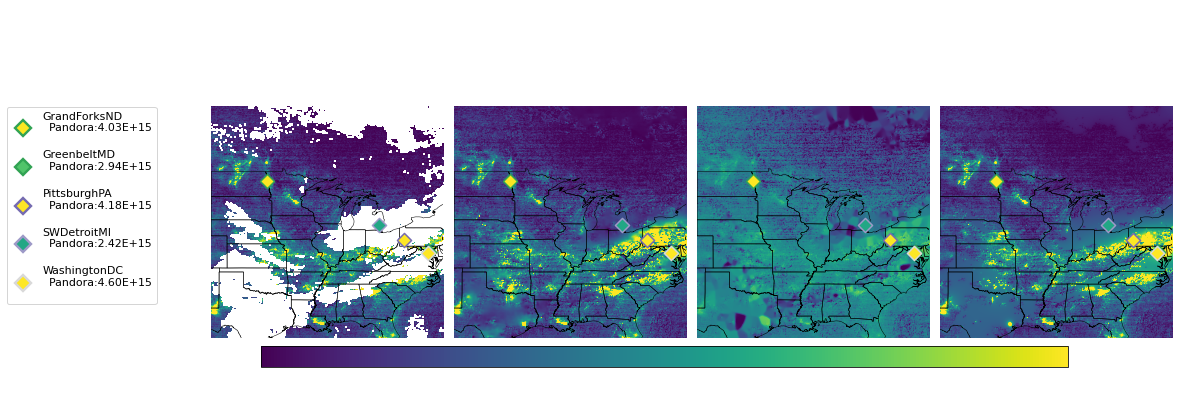

In [9]:
from scipy.spatial import cKDTree
import cv2
# ---- baselines ----
def telea_inpaint(image, mask):
    img8 = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    hole_mask = (mask == 0).astype(np.uint8)
    filled = cv2.inpaint(img8, hole_mask, 3, cv2.INPAINT_TELEA)
    return filled.astype(np.float32) / 255.0

def idw_inpaint(image, known, power=2):
    y, x = np.indices(image.shape)
    known_pts = np.column_stack(np.nonzero(known))
    if len(known_pts) == 0: return image
    known_vals = image[known_pts[:, 0], known_pts[:, 1]]
    filled = image.copy()
    missing_pts = np.column_stack(np.nonzero(~known))
    for r, c in missing_pts:
        dist2 = (known_pts[:, 0]-r)**2 + (known_pts[:, 1]-c)**2
        dist2[dist2 == 0] = 1e-6
        w = 1 / (dist2 ** (power/2))
        w /= np.sum(w)
        filled[r, c] = np.sum(w * known_vals)
    return filled


# ---- visualization ----
def visualize_sample_or_batch(
    sample=None,
    dataloader=None,
    labcolor = 'white',
    alpha = 0.5,
    batch_idx=0,
    sample_idx=0,
    model=None,
    normalizer=None,
    device="cuda",
    inference=True,
    shp_path=None,
    pandora_df=None,
    station_color_map=None,
    save=False,
    save_path="comparison_model_telea_idw.png"
):
    """Visualize Model, TELEA, and IDW predictions with Pandora overlays."""

    if sample is None and dataloader is not None:
        for i, batch in enumerate(dataloader):
            if i == batch_idx: break
        sample = {k: (v[sample_idx] if isinstance(v, torch.Tensor) else v)
                  for k, v in batch.items()}
    if sample is None:
        raise ValueError("Must provide sample or dataloader.")

    masked = sample["masked_img"][0].numpy()
    target = sample["target"][0].numpy()
    known_mask = sample["known_mask"][0].numpy().astype(bool)
    
    
    if hasattr(normalizer, "denormalize_image"):
        masked = normalizer.denormalize_image(masked)
        target = normalizer.denormalize_image(target)
        
        
    path = sample["path"][0]
    date_str = path.split("/")[-1].split(".")[0]
    date = datetime.strptime(date_str[:14], "%Y%m%d%H%M%S")
    with rasterio.open(path) as src:
        tr, crs = src.transform, src.crs
        H, W = src.height, src.width
    xmin, ymin, xmax, ymax = array_bounds(H, W, tr)
    segments = load_shapefile_segments_pyshp(shp_path, crs) if shp_path else []
    ts = date

    p_val_map = sample.get("p_val_mask", None)
    if p_val_map is not None and torch.is_tensor(p_val_map):
        p_val_map = p_val_map.numpy().astype(np.float64)
        p_val_map[p_val_map == 0.0] = np.nan

    model_pred = None
    if inference and model is not None:
        model.eval()
        with torch.no_grad():
            img = sample["masked_img"].unsqueeze(0).to(device)
            mask = sample["known_mask"].unsqueeze(0).to(device)
            pred, _ = model(img, mask)
            model_pred = normalizer.denormalize_image(pred[0, 0].cpu().numpy())
            
    
    img_norm = sample["masked_img"][0].numpy().astype(np.float32)          # normalized
    known_mask = sample["known_mask"][0].numpy().astype(bool)

    telea_pred_norm = telea_inpaint(img_norm, known_mask)
    t_pred = normalizer.denormalize_image(telea_pred_norm)
    
#     idw_pred = alpha * model_pred + (1 - alpha) * t_pred
    idw_pred = idw_inpaint(masked, known_mask)
    
    
    pred_np_final = None
    pred_idw_final = None
    pred_tel_final = None
    pandora_rmse = None
    pandora_rho  = None


    pred_np_final = model_pred.copy()
    pred_idw_final = idw_pred.copy()
    pred_tel_final = t_pred.copy()

    pred_tel_final[~mask[0,0].cpu().numpy().astype(bool)] = t_pred[~mask[0,0].cpu().numpy().astype(bool)]
    pred_idw_final[~mask[0,0].cpu().numpy().astype(bool)] = idw_pred[~mask[0,0].cpu().numpy().astype(bool)]
    pred_np_final[~mask[0,0].cpu().numpy().astype(bool)] = model_pred[~mask[0,0].cpu().numpy().astype(bool)]
    # Pandora RMSE/ρ
    p_mask = sample.get("p_mask", torch.zeros_like(sample["known_mask"])).numpy().astype(bool)
    if p_mask.any():
        pandora_rows, pandora_cols = np.where(p_mask)
        pandora_values = p_val_map[pandora_rows, pandora_cols]
 
        pred_at_pandora = pred_np_final[pandora_rows, pandora_cols]
        idw_at_pandora = pred_idw_final[pandora_rows, pandora_cols]
        tel_at_pandora = pred_tel_final[pandora_rows, pandora_cols]
        
        valid_mask = np.isfinite(pandora_values) & np.isfinite(pred_at_pandora)
        valid_idw_mask = np.isfinite(pandora_values) & np.isfinite(idw_at_pandora)
        valid_tel_mask = np.isfinite(pandora_values) & np.isfinite(tel_at_pandora)
        
        if valid_mask.sum() > 0:
            pandora_valid = pandora_values[valid_mask]
            pred_valid = pred_at_pandora[valid_mask]
            pandora_rmse = np.sqrt(np.mean((pandora_valid - pred_valid) ** 2))
            from scipy import stats
            pandora_rho, _ = stats.spearmanr(pandora_valid, pred_valid)
        
        if valid_idw_mask.sum() > 0:
            pandora_valid = pandora_values[valid_idw_mask]
            pred_valid_idw = idw_at_pandora[valid_idw_mask]
            pandora_rmse_idw = np.sqrt(np.mean((pandora_valid - pred_valid_idw) ** 2))
            pandora_rho_idw, _ = stats.spearmanr(pandora_valid, pred_valid_idw)
        
        if valid_tel_mask.sum() > 0:
            pandora_valid = pandora_values[valid_tel_mask]
            pred_valid_tel = tel_at_pandora[valid_tel_mask]
            pandora_rmse_tel = np.sqrt(np.mean((pandora_valid - pred_valid_tel) ** 2))
            pandora_rho_tel, _ = stats.spearmanr(pandora_valid, pred_valid_tel)

    # ---------- 4. color scale ----------
    finite_vals = target[np.isfinite(target)]
    vmin, vmax = np.percentile(finite_vals, [2, 98]) if finite_vals.size else (0, 1)
    cmap_v = plt.cm.viridis.copy(); cmap_v.set_bad("white")

    # ---------- 5. Pandora overlay helpers ----------
    def _add_pandora_stations(ax, tr, crs, H, W, ts, p_val_map, vmin, vmax, cmap_v,
                              pandora_df, station_color_map, add_legend=False, pred_np_final=None):
        legend_handles = []
        if pandora_df is None or ts is pd.NaT: return legend_handles

        dfw = pandora_df[(pandora_df["datetime"] >= ts - pd.Timedelta("30min")) &
                         (pandora_df["datetime"] <= ts + pd.Timedelta("30min"))].copy()
        if dfw.empty: return legend_handles
        if "station" in dfw.columns:
            dfw["abs_dt"] = (dfw["datetime"] - ts).abs()
            dfw = dfw.sort_values(["station","abs_dt"]).groupby("station",as_index=False).first()

        lons = _wrap_lon_180(pd.to_numeric(dfw["lon"], errors="coerce").to_numpy())
        lats = pd.to_numeric(dfw["lat"], errors="coerce").to_numpy()
        ok = np.isfinite(lons)&np.isfinite(lats)&(lats>=-90)&(lats<=90)
        dfw = dfw.loc[ok]
        rr, cc = _lonlat_to_rowcol_vec(lons[ok], lats[ok], tr, crs)
        labels = dfw["station"].astype(str).to_numpy()

        rr_i, cc_i = rr.astype(int), cc.astype(int)
        ok_in = (rr_i>=0)&(rr_i<H)&(cc_i>=0)&(cc_i<W)
        rr_i, cc_i, labels = rr_i[ok_in], cc_i[ok_in], labels[ok_in]
        if rr_i.size==0: return legend_handles
        xs, ys = _rowcol_to_xy_vec(rr_i, cc_i, tr)

        norm = plt.Normalize(vmin=vmin, vmax=vmax)
        p_val_arr = np.array(p_val_map, dtype=np.float64)
        p_val_arr[p_val_arr==0.0]=np.nan
        valid_mask = np.isfinite(p_val_arr)
        if not np.any(valid_mask): return legend_handles
        valid_coords = np.argwhere(valid_mask)
        valid_values = p_val_arr[valid_mask]
        tree = cKDTree(valid_coords)

        for x,y,lab,r,c in zip(xs,ys,labels,rr_i,cc_i):
            outline_color = station_color_map.get(lab,"red") if station_color_map else "red"
            dist, idx = tree.query(np.array([r,c]))
            pandora_val = valid_values[idx]
            fill_color = cmap_v(norm(pandora_val)) if np.isfinite(pandora_val) else "black"
            ax.scatter(x, y, s=100, marker="D", facecolor=fill_color,
                       edgecolor=outline_color, linewidth=1.5, zorder=6)
            if add_legend:
                label_text = lab
                if pred_np_final is not None and np.isfinite(pandora_val):
                    pred_val = pred_np_final[r,c]
                    if np.isfinite(pred_val):
                        rmse = np.sqrt((pandora_val - pred_val)**2)
                        label_text += f"\n  Pandora:{pandora_val:.2E}\n  "#Prediction:{pred_val:.2E}"   # append RMSE here
#                         label += f"\nRMSE={rmse:.2E}"
                proxy = Line2D([0],[0], marker="D", color="none",
                               markerfacecolor=fill_color,
                               markeredgecolor=outline_color, markeredgewidth=2.4,
                               markersize=10, label=label_text)
                legend_handles.append(proxy)
        return legend_handles

    def add_pandora_stations(ax, add_legend=True, pred_np_final=None):
        return _add_pandora_stations(ax, tr, crs, H, W, ts, p_val_map, vmin, vmax,
                                     cmap_v, pandora_df, station_color_map,
                                     add_legend=add_legend, pred_np_final=pred_np_final)


    # ---------- 7. Panels: Input, Model, IDW, Target (explicit axes) ----------
    fig, ax = plt.subplots(1, 4, figsize=(16, 5))
    disp_inp = np.ma.masked_invalid(np.ma.array(masked, mask=~known_mask))
    im0 = ax[0].imshow(disp_inp,cmap=cmap_v,vmin=vmin,vmax=vmax,extent=[xmin, xmax, ymin, ymax],origin="upper")
    ax[0].add_collection(LineCollection(segments, colors="k", linewidths=0.5))
    ax[0].set_xlim(xmin, xmax);ax[0].set_ylim(ymin, ymax)
    ax[0].set_aspect("equal", adjustable="box")
    ax[0].set_title("Input (N/A=white)", fontsize=13, color=labcolor)
    ax[0].axis("off")
    legend_handles = add_pandora_stations(ax[0], add_legend=True, pred_np_final=masked)

    # ---------- Panel 1: Model prediction ----------
    if inference and model_pred is not None:
        disp_model = np.ma.masked_invalid(model_pred)
        im1 = ax[1].imshow(disp_model,cmap=cmap_v, vmin=vmin,vmax=vmax,extent=[xmin, xmax, ymin, ymax],origin="upper")
        add_pandora_stations(ax[1], add_legend=False, pred_np_final=model_pred)
        ax[1].set_title(f"UNet Prediction\nRMSE: {pandora_rmse:.2E} | ρ: {pandora_rho:.2f}", fontsize=13, color=labcolor)
    else:
        im1 = ax[1].imshow(np.ma.array(target, mask=~np.isfinite(target)),cmap=cmap_v, vmin=vmin, vmax=vmax,extent=[xmin, xmax, ymin, ymax],origin="upper")
        add_pandora_stations(ax[1], add_legend=False)
        ax[1].set_title("Original TEMPO Data", fontsize=13)
    ax[1].add_collection(LineCollection(segments, colors="k", linewidths=0.5))
    ax[1].axis("off")

    # ---------- Panel 2: TEL baseline ----------
    disp_tel = np.ma.masked_invalid(t_pred)
    im2 = ax[2].imshow(
        disp_tel,
        cmap=cmap_v,
#         vmin=vmin,
#         vmax=vmax,
        extent=[xmin, xmax, ymin, ymax],
        origin="upper",
    )
    add_pandora_stations(ax[2], add_legend=False, pred_np_final=t_pred)
    ax[2].add_collection(LineCollection(segments, colors="k", linewidths=0.5))
    ax[2].set_title(f"TELEA Baseline\nRMSE: {pandora_rmse_tel:.2E} | ρ: {pandora_rho_tel:.2f}", fontsize=13, color=labcolor)
    ax[2].axis("off")
    
    # ---------- Panel 3: IDW baseline ----------
    disp_idw = np.ma.masked_invalid(idw_pred)
    im3 = ax[3].imshow(
        disp_idw,
        cmap=cmap_v,
        vmin=vmin,
        vmax=vmax,
        extent=[xmin, xmax, ymin, ymax],
        origin="upper",
    )
    add_pandora_stations(ax[3], add_legend=False, pred_np_final=idw_pred)
    ax[3].add_collection(LineCollection(segments, colors="k", linewidths=0.5))
    ax[3].set_title(f"IDW Baseline\nRMSE: {pandora_rmse_idw:.2E} | ρ: {pandora_rho_idw:.2f}", fontsize=13, color=labcolor)
#     ax[3].set_title(f"comb", fontsize=15, color="black")

    ax[3].axis("off")
    
    # ---------- Panel 3: Target ----------
#     disp_targ = np.ma.masked_invalid(target)
#     im3 = ax[4].imshow(disp_targ,cmap=cmap_v,vmin=vmin,vmax=vmax,extent=[xmin, xmax, ymin, ymax],origin="upper")
#     add_pandora_stations(ax[4], add_legend=False, pred_np_final=target)
#     ax[4].add_collection(LineCollection(segments, colors="k", linewidths=0.5))
#     ax[4].set_title("Ground Truth TEMPO", fontsize=13, color=labcolor)
#     ax[4].axis("off")

    if legend_handles:ax[0].legend(handles=legend_handles,bbox_to_anchor=(-0.90, 1.02),loc="upper left",frameon=True,fontsize=11,markerscale=1.2)
    cbar_ax = fig.add_axes([0.2, 0.0001, 0.7, 0.06])
    cbar_ax.tick_params(axis="x", colors=labcolor, labelcolor=labcolor)
    fig.colorbar(im1, cax=cbar_ax, orientation="horizontal").set_label("NO₂ (molec·cm$^{-2}$)", fontsize=15, color=labcolor)
    plt.suptitle(f"Inpainting Comparison Between PConvUnet, TELEA, IDW\n{date.strftime('%Y-%m-%d %H:%M:%S')}\n", fontsize=18, y=1.0, color=labcolor)
    plt.tight_layout()
    if save:plt.savefig("all_clear.png", dpi=300, bbox_inches="tight", transparent=False) #facecolor='white'
    plt.show()
    plt.close()
    
    
# for i in range(33,40):
#     for j in range(0,4):
#         print(i,j)
visualize_sample_or_batch(dataloader=val_loader, labcolor = 'white',alpha = 0.6, batch_idx=33, sample_idx=1, model=model, normalizer=normalizer,
        device="cuda", shp_path=shp_path,pandora_df=pandora_df,station_color_map=station_color_map, inference=True, save=True)
# for i in range(20,40):
# # ass = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# # for a in ass:
#     for j in range(0,4):
        
#         visualize_sample_or_batch(dataloader=val_loader, alpha = 0.8, batch_idx=i, sample_idx=j, model=model, normalizer=normalizer,
#             device="cuda", shp_path=shp_path,pandora_df=pandora_df,station_color_map=station_color_map, inference=True, save=False)

alpha: 0.2


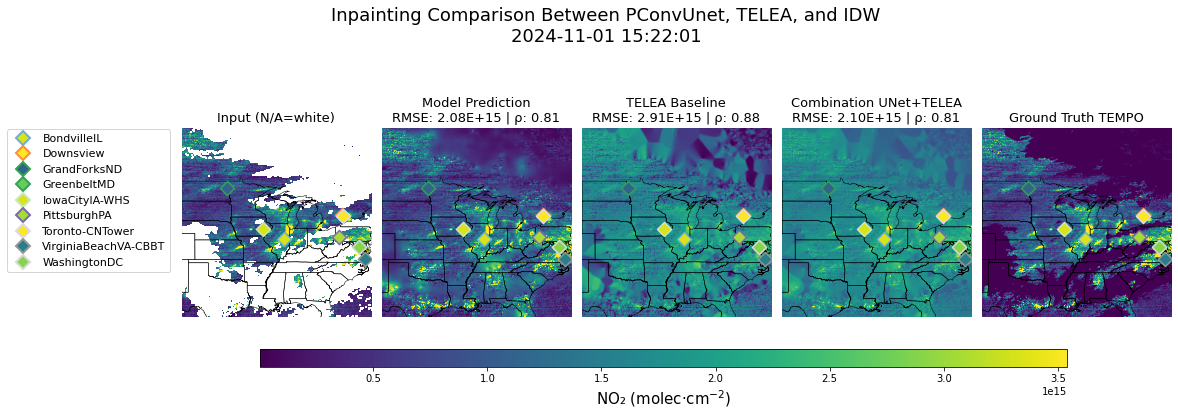

alpha: 0.3


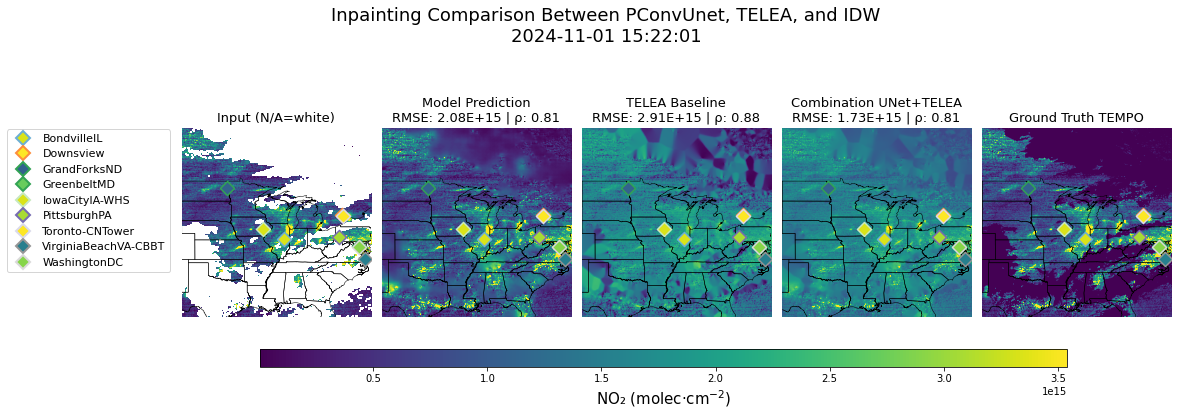

alpha: 0.4


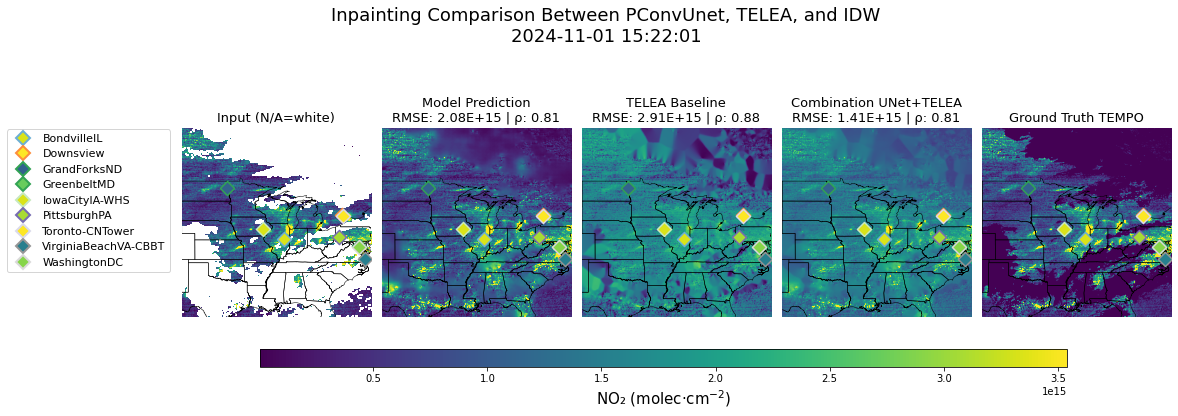

alpha: 0.5


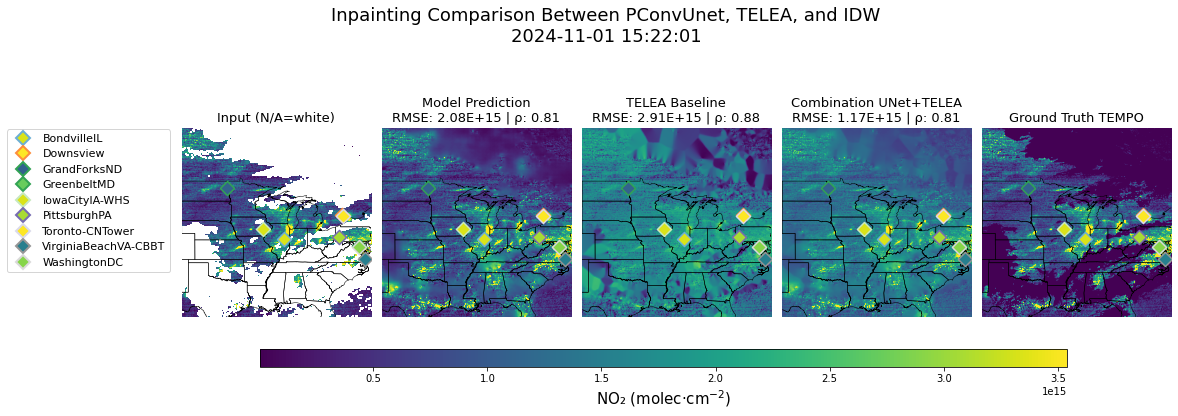

alpha: 0.6


KeyboardInterrupt: 

In [10]:
ass = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for a in ass:
    print(f'alpha: {a}')
    visualize_sample_or_batch(dataloader=val_loader, alpha = a, batch_idx=110, sample_idx=3, model=model, normalizer=normalizer,
        device="cuda", shp_path=shp_path,pandora_df=pandora_df,station_color_map=station_color_map, inference=True, save=False)

  0%|          | 0/208 [00:00<?, ?it/s]

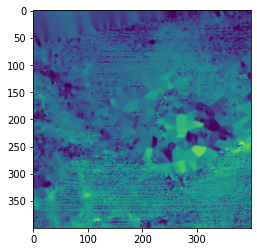

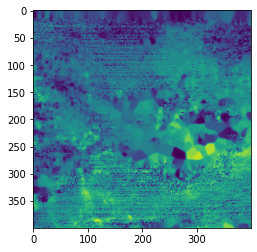

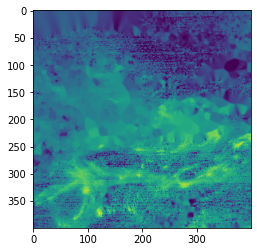

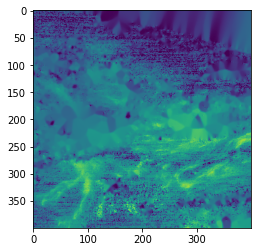

  0%|          | 1/208 [00:01<06:11,  1.80s/it]

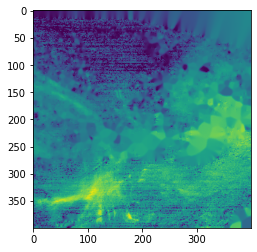

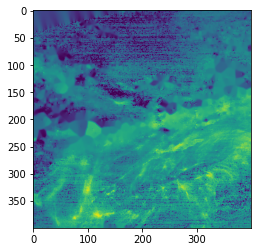

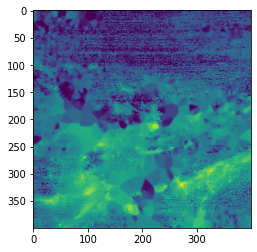

  0%|          | 1/208 [00:03<10:48,  3.13s/it]


KeyboardInterrupt: 

In [11]:
import numpy as np
from scipy import stats
from scipy.ndimage import gaussian_filter
import cv2
def eval_pandora_metrics_idw(normalizer, dataloader):
    """
    Evaluate the IDW baseline using Pandora stations as validation points.
    Computes RMSE, Spearman rho, and Pearson r for each sample.
    """
    results = []

    for batch in tqdm(dataloader):
        B = batch["masked_img"].shape[0]
        for b in range(B):
            # --- 1. Extract numpy arrays ---
            img = batch["masked_img"][b, 0].cpu().numpy()        # (H,W)
            target = batch["target"][b, 0].cpu().numpy()         # (H,W)
            mask_obs = batch["known_mask"][b, 0].cpu().numpy() > 0.5  # (H,W) boolean

            # --- 2. Run IDW inpainting ---
            pred_np = telea_inpaint(img, mask_obs)

            # --- 3. Denormalize both ---
            if hasattr(normalizer, "denormalize_image"):
                pred_np = normalizer.denormalize_image(pred_np)
                tgt_np = normalizer.denormalize_image(target)
            else:
                tgt_np = target
                
#             plt.imshow(pred_np)
#             plt.show()

            # Optional smoothing to match CNN output
            pred_np = gaussian_filter(pred_np, sigma=0.5)

            # --- 4. Pandora comparison ---
            p_mask = batch.get("p_mask", torch.zeros_like(batch["known_mask"]))[b].cpu().numpy().astype(bool)
            p_val_map = batch.get("p_val_mask", torch.zeros_like(batch["known_mask"]))[b].cpu().numpy()

            pandora_rmse, pandora_rho, pandora_r, n_pandora = None, None, None, 0
            if p_mask.any():
                rows, cols = np.where(p_mask)
                pandora_values = p_val_map[rows, cols]

                # Denormalize Pandora values
                if hasattr(normalizer, 'denormalize_pandora_array'):
                    pandora_values = normalizer.denormalize_pandora_array(pandora_values)
                elif hasattr(normalizer, 'denormalize_pandora'):
                    pandora_values = np.array([normalizer.denormalize_pandora(v) for v in pandora_values])

                pred_at_pandora = pred_np[rows, cols]
                valid_mask = np.isfinite(pandora_values) & np.isfinite(pred_at_pandora)

                if np.any(valid_mask):
                    pandora_valid = pandora_values[valid_mask]
                    pred_valid = pred_at_pandora[valid_mask]

                    pandora_rmse = np.sqrt(np.mean((pandora_valid - pred_valid) ** 2))
                    if len(pandora_valid) > 1:
                        pandora_rho, _ = stats.spearmanr(pandora_valid, pred_valid)
                        pandora_r, _ = stats.pearsonr(pandora_valid, pred_valid)
                    n_pandora = len(pandora_valid)

#                 print(pandora_rho, pandora_rmse, pandora_r)
            results.append({
                "rho": pandora_rho,
                "rmse": pandora_rmse,
                "n_pandora": n_pandora,
                "r": pandora_r
            })

    return results
idw_metrics = eval_pandora_metrics_idw(normalizer, val_loader)

# Aggregate results safely
all_rhos  = [m["rho"] for m in idw_metrics if m["rho"] is not None]
all_rmses = [m["rmse"] for m in idw_metrics if m["rmse"] is not None]
all_rs    = [m["r"] for m in idw_metrics if m["r"] is not None]

print(f"Avg Spearman ρ: {np.nanmean(all_rhos):.3f}")
print(f"Avg RMSE:       {np.nanmean(all_rmses):.4E}")
print(f"Avg Pearson r:  {np.nanmean(all_rs):.3f}")


In [14]:
import torch
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy import stats

def eval_pandora_metrics(model, normalizer, dataloader, device="cuda"):
    """
    Iterate over dataloader, compute Pandora RMSE and Spearman rho for each sample.
    Returns list of dicts with metrics for each sample.
    """
    model.eval()
    results = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            B = batch["masked_img"].shape[0]
            for b in range(B):
                # Extract single sample
                img = batch["masked_img"][b:b+1].to(device)       # [1,1,H,W]
                target = batch["target"][b:b+1].to(device)
                mask_obs = batch["known_mask"][b:b+1].to(device)

                if "known_and_fake_mask" in batch:
                    mask = batch["known_and_fake_mask"][b:b+1].to(device)
                else:
                    mask = mask_obs

                # Model prediction
                pred, _ = model(img, mask)

                # Denormalize
                pred_np = normalizer.denormalize_image(pred[0,0].cpu().numpy())
                tgt_np = normalizer.denormalize_image(target[0,0].cpu().numpy())

                # Smooth prediction
                pred_np = gaussian_filter(pred_np, sigma=0.5)

                # Pandora data
                p_mask = batch.get("p_mask", torch.zeros_like(batch["known_mask"]))[b].cpu().numpy().astype(bool)
                p_val_map = batch.get("p_val_mask", torch.zeros_like(batch["known_mask"]))[b].cpu().numpy()

                pandora_rmse, pandora_rho, pandora_r, n_pandora = None, None, None, 0
                if p_mask.any():
                    rows, cols = np.where(p_mask)
                    if len(rows) > 0:
                        pandora_values = p_val_map[rows, cols]

                        # Denormalize Pandora if possible
                        if hasattr(normalizer, 'denormalize_pandora_array'):
                            pandora_values = normalizer.denormalize_pandora_array(pandora_values)
                        elif hasattr(normalizer, 'denormalize_pandora'):
                            pandora_values = np.array([normalizer.denormalize_pandora(v) for v in pandora_values])

                        pred_at_pandora = pred_np[rows, cols]

                        valid_mask = np.isfinite(pandora_values) & np.isfinite(pred_at_pandora)
                        if valid_mask.sum() > 0:
                            pandora_valid = pandora_values[valid_mask]
                            pred_valid = pred_at_pandora[valid_mask]

                            pandora_rmse = np.sqrt(np.mean((pandora_valid - pred_valid)**2))
                            if len(pandora_valid) > 1:
                                pandora_rho, _ = stats.spearmanr(pandora_valid, pred_valid)
                                pandora_r, _ = stats.pearsonr(pandora_valid, pred_valid)
                            n_pandora = len(pandora_valid)
#                         print(pandora_rho, pandora_rmse, pandora_r)
                results.append({
                    "rho": pandora_rho,
                    "rmse": pandora_rmse,
                    "n_pandora": n_pandora,
                    "r":pandora_r
                })

    return results
metrics = eval_pandora_metrics(model, normalizer, val_loader, device="cuda")

# For example, aggregate results
all_rhos  = [m["rho"] for m in metrics if m["rho"] is not None]
all_rmses = [m["rmse"] for m in metrics if m["rmse"] is not None]
all_rs = [m["r"] for m in metrics if m["r"] is not None]

print(f"Avg rho:  {np.nanmean(all_rhos):.3f}")
print(f"Avg RMSE: {np.nanmean(all_rmses):.4E}")
print(f"Avg r:  {np.nanmean(all_rs):.3f}")



100%|██████████| 208/208 [02:15<00:00,  1.53it/s]

Avg rho:  0.444
Avg RMSE: 2.6416E+15
Avg r:  0.447


In [11]:
import torch
import numpy as np
from tqdm import tqdm
from scipy import stats
from scipy.ndimage import gaussian_filter


def eval_pandora_metrics(model, normalizer, dataloader, device="cuda"):
    """
    Evaluate model performance over the validation set
    using Pandora measurements within *true TEMPO missing regions* only.
    Returns both the per-sample results list and aggregated averages.
    """
    model.eval()
    results = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating Pandora metrics"):
            B = batch["masked_img"].shape[0]

            for b in range(B):
                img        = batch["masked_img"][b:b+1].to(device)
                target     = batch["target"][b:b+1].to(device)
                known_mask = batch["known_mask"][b:b+1].to(device)  # 1 = valid TEMPO pixel

                # Forward pass using known_mask (not artificial mask)
                pred, _ = model(img, known_mask)

                # Denormalize to physical units
                pred_np = normalizer.denormalize_image(pred[0, 0].cpu().numpy())
                tgt_np  = normalizer.denormalize_image(target[0, 0].cpu().numpy())

                # Optional mild smoothing for stability
                pred_np = gaussian_filter(pred_np, sigma=0.5)

                # Pandora data
                p_mask = batch.get("p_mask", torch.zeros_like(batch["known_mask"]))[b].cpu().numpy().astype(bool)
                p_val_map = batch.get("p_val_mask", torch.zeros_like(batch["known_mask"]))[b].cpu().numpy()

                # Restrict to *true missing regions* only
                missing_mask = (known_mask[0, 0].cpu().numpy() == 0)
                pandora_region = p_mask & missing_mask

                # Compute metrics only where Pandora exists within missing region
                rmse = rho = r = bias = None
                n_pandora = np.count_nonzero(pandora_region)

                if n_pandora > 0:
                    rows, cols = np.where(pandora_region)
                    pandora_values = p_val_map[rows, cols]

                    # Denormalize Pandora values if function provided
                    if hasattr(normalizer, "denormalize_pandora_array"):
                        pandora_values = normalizer.denormalize_pandora_array(pandora_values)
                    elif hasattr(normalizer, "denormalize_pandora"):
                        pandora_values = np.array(
                            [normalizer.denormalize_pandora(v) for v in pandora_values]
                        )

                    pred_values = pred_np[rows, cols]
                    valid_mask = np.isfinite(pandora_values) & np.isfinite(pred_values)

                    if np.any(valid_mask):
                        pandora_valid = pandora_values[valid_mask]
                        pred_valid = pred_values[valid_mask]

                        rmse = np.sqrt(np.mean((pandora_valid - pred_valid) ** 2))
                        bias = np.mean(pred_valid - pandora_valid)
                        if len(pandora_valid) > 1:
                            rho, _ = stats.spearmanr(pandora_valid, pred_valid)
                            r, _ = stats.pearsonr(pandora_valid, pred_valid)

                results.append({
                    "rho": rho,
                    "r": r,
                    "rmse": rmse,
                    "bias": bias,
                    "n_pandora": n_pandora,
                })

    # ---- Aggregate results ----
    def safe_mean(values):
        vals = [v for v in values if v is not None and not np.isnan(v)]
        return np.nan if len(vals) == 0 else float(np.nanmean(vals))

    avg_rho  = safe_mean([m["rho"] for m in results])
    avg_r    = safe_mean([m["r"] for m in results])
    avg_rmse = safe_mean([m["rmse"] for m in results])
    avg_bias = safe_mean([m["bias"] for m in results])

    print("\n=== Pandora Validation Metrics (True Missing Regions) ===")
    print(f"Avg Spearman ρ : {avg_rho:.3f}")
    print(f"Avg Pearson  r : {avg_r:.3f}")
    print(f"Avg RMSE       : {avg_rmse:.4E}")
    print(f"Avg Bias       : {avg_bias:.4E}")

    return results, {
        "rho": avg_rho,
        "r": avg_r,
        "rmse": avg_rmse,
        "bias": avg_bias,
    }
results, summary = eval_pandora_metrics(model, normalizer, val_loader, device="cuda")


Evaluating Pandora metrics: 100%|██████████| 208/208 [02:20<00:00,  1.48it/s]


=== Pandora Validation Metrics (True Missing Regions) ===
Avg Spearman ρ : 0.248
Avg Pearson  r : 0.245
Avg RMSE       : 2.5199E+15
Avg Bias       : -7.3668E+14


In [9]:
def train_model(model, normalizer, train_loader, val_loader, shp_path, epochs=50):
    opt = torch.optim.Adam(model.parameters(), lr=1e-5)
    best_loss = float("inf")
    best_state = None
    wait = 0
    history = []
    
    for epoch in range(epochs):
        train_loader.dataset.current_epoch = epoch
        train_loader.dataset.max_epochs = epochs
        # ---- Training ----
        model.train()
        train_loss = 0
        train_metrics = {'rmse': 0.0, 'mae': 0.0, 'r2': 0.0,'pandora_rmse': 0.0, 'pandora_mae': 0.0, 'pandora_rho': 0.0, 'pandora_r2': 0.0,'n_pandora_stations': 0}
        train_batch_count = 0
        
        for batch in tqdm(train_loader):
            img = batch["masked_img"].cuda()          # img with both masks
            mask = batch["known_and_fake_mask"].cuda()      # real missing gaps and artificial gaps
            mask_aug = batch["fake_mask"].cuda()            # 1=kept, 0=artificial hole
            known_mask = batch['known_mask'].cuda()
            target = batch["target"].cuda()
            p_mask = batch["p_mask"]
            p_val_map = batch["p_val_mask"]

            # If Pandora data exists, move to device
            if p_mask is not None:
                p_mask = p_mask.cuda()
                p_val_map = p_val_map.cuda() if p_val_map is not None else None

            pred_t, _ = model(img, mask_aug)
            
            # === Telea-model fusion ===
            telea_pred = batch.get("telea_pred", None)
            alpha = 0.7   # weight for UNet; 0.7–0.9 typically best
            if telea_pred is not None:
                telea_pred = telea_pred.cuda()
                pred_t = alpha * pred_t + (1 - alpha) * telea_pred
            loss = improved_loss_progress(pred_t, target, mask_aug, epoch, max_epochs=epochs)           
            opt.zero_grad(); loss.backward(); opt.step()
            train_loss += loss.item()
            
        
            # Calculate metrics for fake mask regions
            batch_metrics = calculate_metrics(pred_t, target, mask_aug, known_mask, 
                                              p_mask=p_mask, p_values=p_val_map, normalizer=normalizer)

            for key in batch_metrics:
                if key not in train_metrics:
                    train_metrics[key] = 0.0
                train_metrics[key] += batch_metrics[key]

            train_batch_count += 1
        
            
        for key in train_metrics:
            train_metrics[key] /= train_batch_count
        train_loss /= len(train_loader)

        # ---- Validation (Simple Version) ----
        model.eval()
        val_loader.dataset.current_epoch=0
        val_loader.dataset.max_epochs =1
        val_loss = 0
        val_metrics = {
            'pandora_rmse': 0.0, 'pandora_mae': 0.0, 'pandora_rho': 0.0, 'pandora_r2': 0.0,
            'n_pandora_stations': 0
        }
        val_batch_count = 0

        with torch.no_grad():
            for batch in tqdm(val_loader):
                img = batch["masked_img"].cuda()
                mask = batch["known_mask"].cuda()
                target = batch["target"].cuda()
                p_mask = batch["p_mask"]
                p_val_map = batch["p_val_mask"]

                if p_mask is not None:
                    p_mask = p_mask.cuda()
                    p_val_map = p_val_map.cuda() if p_val_map is not None else None

                pred, _ = model(img, mask)
                telea_pred = batch.get("telea_pred", None)
                if telea_pred is not None:
                    telea_pred = telea_pred.cuda()
                    pred = alpha * pred + (1 - alpha) * telea_pred
                loss = improved_loss_progress(pred, target, mask, epoch, max_epochs=epochs)
                val_loss += loss.item()

                # Calculate metrics for first sample in batch only (faster)
                batch_metrics = calculate_metrics(
                    pred, target, mask, mask,  # Use known_mask for both
                    p_mask=p_mask, p_values=p_val_map, normalizer=normalizer,
                )

                # Add to validation totals
                for key in val_metrics:
                    val_metrics[key] += batch_metrics[key]

                val_batch_count += 1

        # Average validation metrics and loss over all batches
        val_loss /= len(val_loader)
        for key in val_metrics:
            val_metrics[key] /= val_batch_count

        print(f"Epoch {epoch+1}: Train {train_loss:.4f} | Val {val_loss:.4f}")
        print(f"Train metrics - RMSE: {train_metrics['rmse']:.4f}, MAE: {train_metrics['mae']:.4f}, R²: {train_metrics['r2']:.4f}")   
        
        if train_metrics['n_pandora_stations'] > 0:
            print(f"Train Pandora metrics - RMSE: {train_metrics['pandora_rmse']:.4E}, "
                  f"MAE: {train_metrics['pandora_mae']:.4E}, "
                  f"ρ: {train_metrics['pandora_rho']:.2f}, "
                  f"R²: {train_metrics['pandora_r2']:.2f}")
                  
        if val_metrics['n_pandora_stations'] > 0:
            print(f"Val Pandora metrics - RMSE: {val_metrics['pandora_rmse']:.4E}, "
                  f"MAE: {val_metrics['pandora_mae']:.4E}, "
                  f"ρ: {val_metrics['pandora_rho']:.2f}, "
                  f"R²: {val_metrics['pandora_r2']:.2f}")
        
        # ---- Early stopping ----
        if val_loss < best_loss:
            best_loss = val_loss
            best_state = model.state_dict().copy()
            wait = 0
            torch.save(model.state_dict(), f"pconvunet{epoch}.pt")
        if epoch == epochs-1:
            torch.save(model.state_dict(), "final.pt")
                
        # Store all metrics in history
        epoch_data = {
            "epoch": epoch,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_rmse": train_metrics['rmse'],
            "train_mae": train_metrics['mae'],
            "train_r2": train_metrics['r2'],
            "train_pandora_rmse": train_metrics['pandora_rmse'],
            "train_pandora_mae": train_metrics['pandora_mae'],
            "train_pandora_rho": train_metrics['pandora_rho'],
            "train_pandora_r2": train_metrics['pandora_r2'],
            "train_n_pandora_stations": train_metrics['n_pandora_stations'],
            "val_pandora_rmse": val_metrics['pandora_rmse'],
            "val_pandora_mae": val_metrics['pandora_mae'],
            "val_pandora_rho": val_metrics['pandora_rho'],
            "val_pandora_r2": val_metrics['pandora_r2'],
            "val_n_pandora_stations": val_metrics['n_pandora_stations'],
            "pred_min_range": pred.min().item() if 'pred' in locals() else None,
            "pred_max_range": pred.max().item() if 'pred' in locals() else None
        }
        history.append(epoch_data)
        
        if epoch % 2 == 0: 
            visualize_sample_or_batch(
                    dataloader=val_loader,
                    batch_idx=27, sample_idx=3,
                    model=model,
                    normalizer=normalizer,
                    device="cuda",
                    shp_path=shp_path,
                    pandora_df=pandora_df,
                    inference=True,   # model + stats
                    train=False,
                    station_color_map=station_color_map,
                    save=False)
        # Write all metrics to CSV
        fieldnames = [
            "epoch", "train_loss", "val_loss", 
            "train_rmse", "train_mae", "train_r2",
            "train_pandora_rmse", "train_pandora_mae", "train_pandora_rho", "train_pandora_r2", "train_n_pandora_stations",
            "val_pandora_rmse", "val_pandora_mae", "val_pandora_rho", "val_pandora_r2", "val_n_pandora_stations",
            "pred_min_range", "pred_max_range"
        ]
        
        with open('csv_history.csv', "w", newline="") as f:
            csv_writer = csv.DictWriter(f, fieldnames=fieldnames)
            csv_writer.writeheader()
            csv_writer.writerows(history)
            
        
        
    # Restore best weights
    if best_state is not None:
        model.load_state_dict(best_state)
    return model

train_ds = TempoPandoraInpaintDataset(tif_dir=tif_dir,normalizer=normalizer, train=True, file_list=train_files, pandora_csv=pandora_df)
val_ds = TempoPandoraInpaintDataset(tif_dir=tif_dir, normalizer=normalizer,train=False,file_list=val_files,pandora_csv=pandora_df)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=custom_collate_fn  )
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, collate_fn=custom_collate_fn  )
model = OriginalPlusMinimalAttentionDeepOld(base_ch=32).cuda()  # Your original + tiny attention

# m = train_model(model, normalizer,train_loader, val_loader, shp_path, epochs=100)